# Homework of Ch3. Malware Behavior Log Classification
----
This is the homework snippet of TU-ETP-AD1062 Machine Learning Fundamentals.

For more information, please refer to:
https://sites.google.com/view/tu-ad1062-mlfundamentals/

## HW3.1. Import Packages
----
- Data pre-processing:
    - `pandas`: Used for CSV reading
    - `os`: Used for path join
    - `sklearn.preprocessing.LabelEncoder`: Convert string-based labels into numeric labels
- Classifier training and predicting:
    - `lightgbm`: Gradient boosting (Ch.3)
    - `sklearn.svm.SVC`: Support Vector Machine (Ch.2, Ch.3)
    - `sklearn.neural_network.MLPClassifier`: Multi-Layer Perceptron (Ch.3)
- Performance evaluation:
    - `sklearn.model_selection.cross_validate`: **Automatically** divide your data into training and validation set for k-times, construct classifier and compute the scores, which is for k-fold cross-validation
    - `sklearn.metrics.zero_one_loss`: Used for accuracy evaluation
    - `sklearn.model_selection.train_test_split`: Divide your data into training and validation set for once, then feed into classifier by yourself, observing the score and confusion matrix
    - `mlfund.plot.PlotMetric`: plot confusion matrix (provided by this repository)

In [18]:
!pip install pandas

import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder

import lightgbm as lgb
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier

from mlfund.plot import PlotMetric
from sklearn.metrics import zero_one_loss
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
%matplotlib inline

You are using pip version 19.0.3, however version 19.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


## HW3.2. Data pre-processing
----
The code snippet is used to:
1. Read CSV files,
2. Convert the required part into `numpy.ndarray` for scikit-learn training and predicting, and
3. Convert the string labels into numeric labels by `sklearn.preprocessing.LabelEncoder`, i.e.,:
    - `PWS:Win32/Fareit`: 0
    - `Trojan:HTML/Brocoiner`: 1
    - `Trojan:O97M/Obfuse`: 2
    - ...
    - `VirTool:Win32/VBInject`: 19

### HW3.2.1. Read CSV Files by Pandas
----
Here we simply use `pandas.read_csv` for the csv reading. Notice that:
- The result will be pandas `DataFrame`, however most of machine learning framework accept `numpy.ndarray`, therefore we need to convert it by accessing `.values`
- The first column `id` should be ignored, therefore we accessed the values from the 1-st column instead of 0-th column (i.e., using `.values[:, 1:]`)

In [7]:
# Training set
df_train_feature = pd.read_csv(os.path.join('data', 'hw03_dataset.train.feature.csv'))
df_train_label = pd.read_csv(os.path.join('data', 'hw03_dataset.train.label.csv'))

X_train = df_train_feature.values[:, 1:]
y_train_str = df_train_label.values[:, 1:].reshape(len(df_train_label.values[:, 1:]))


# Testing test
df_test_feature = pd.read_csv(os.path.join('data', 'hw03_dataset.test.feature.csv'))
X_test = df_test_feature.values[:, 1:]

display(df_train_feature)

,id,hooking_1,hooking_2,network_1,network_2,network_3,network_4,network_5,network_6,network_7,...,crypto_8,crypto_9,crypto_10,crypto_11,crypto_12,crypto_13,crypto_14,browser_1,browser_2,browser_3
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,13.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### HW3.2.2. Convert String Label to Numeric Labels
----
Use `LabelEncoder` to convert your string lables into `0`, `1`, `2`, ..., and `19`.

In [10]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train_str)

y_train = label_encoder.transform(y_train_str)

display(label_encoder.classes_)

array(['PWS:Win32/Fareit', 'Trojan:HTML/Brocoiner', 'Trojan:O97M/Obfuse',
       'Trojan:Win32/Azden', 'Trojan:Win32/Casdet',
       'Trojan:Win32/Dynamer', 'Trojan:Win32/Emali',
       'Trojan:Win32/Emotet', 'Trojan:Win32/Fuerboos',
       'Trojan:Win32/Fuery', 'Trojan:Win32/Lokibot',
       'Trojan:Win32/MereTam', 'Trojan:Win32/Occamy',
       'Trojan:Win32/Pynamer', 'Trojan:Win32/Skeeyah',
       'Trojan:Win32/Sonbokli', 'Trojan:Win32/Tiggre',
       'TrojanDownloader:O97M/Donoff', 'TrojanDownloader:O97M/Obfuse',
       'VirTool:Win32/VBInject'], dtype=object)

## HW3.3. Construct your Classifier
----
Build your classifier, with parameters fine-tuned.

> **Your task: HW3.3.1.**  
> Training and Predicting for only once, keep adjusting your `create_clf`, and making sure the parameter is not too bad  
> Here we leverage the `train_test_split`, divide your training data `X_train` and `y_train` into:
> - 80% `X1`, `y1`, as training set in this round
> - 20% `X2`, `y2`, as testing set in this round
>
> In this round, you're able to observe the confusion matrix, and you're able to check if data from each class is well-classified.


In [14]:
def create_clf():
    # You can use:
    #     sklearn.svm.SVC,
    #     sklearn.svm.LinearSVC,
    #     sklearn.neural_network.MLPClassifier,
    #     sklearn.ensemble.GradientBoostingClassifier
    #     ...
    # Or any classifier you found!
    # Remember to fine-tune the model parameters
    
    return LinearSVC()

In [15]:
X1, X2, y1, y2 = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [22]:
model = create_clf()
model.fit(X1, y1)

c:\python36\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

Error rate = 0.677


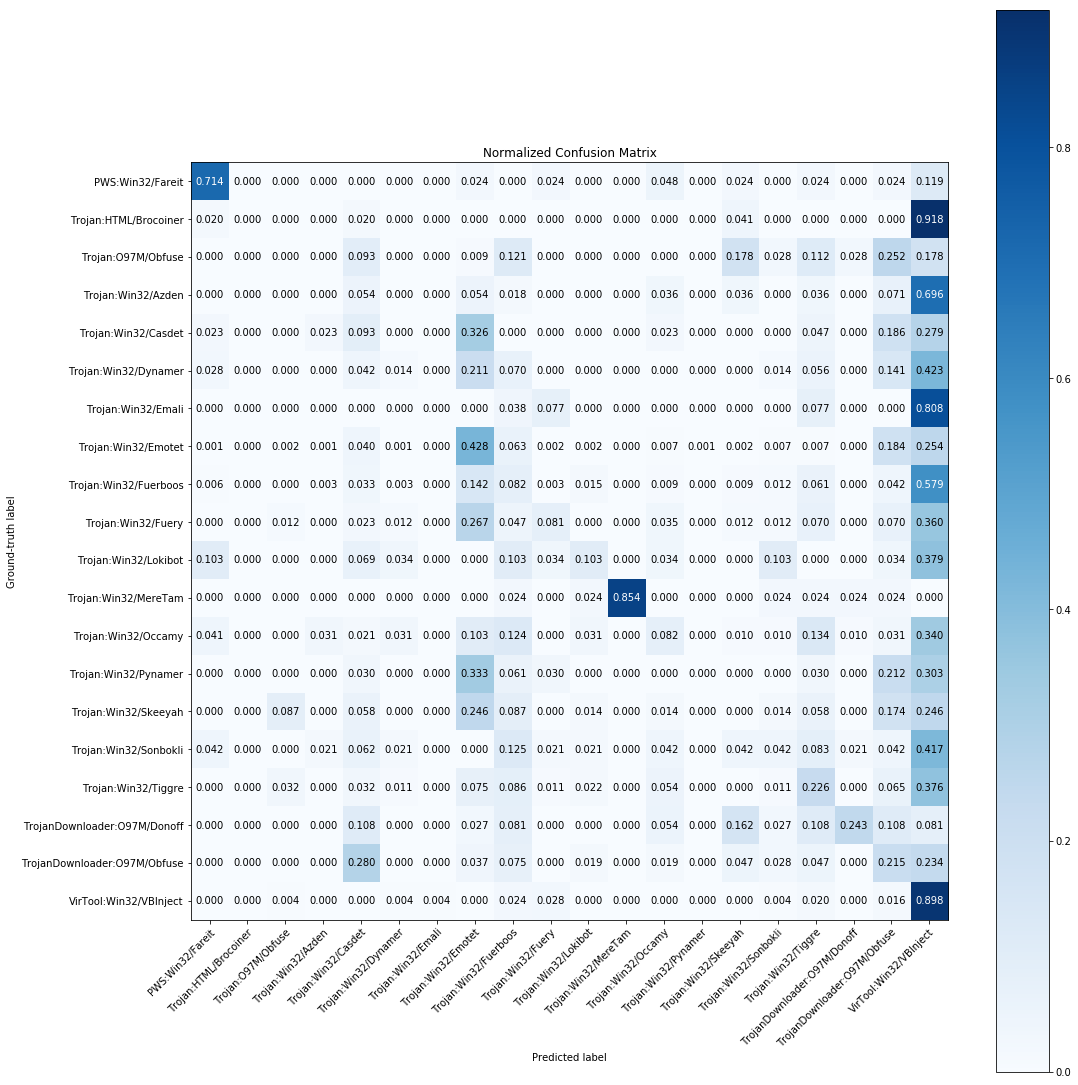

In [28]:
y2_predict = model.predict(X2)

# Error rate
err_01loss = zero_one_loss(y2, y2_predict)
print('Error rate = %2.3f' % err_01loss)

# Confusion matrix of prediction
plot_conf_mat = PlotMetric()
plot_conf_mat.set_labels(label_encoder.classes_.tolist())
plot_conf_mat.confusion_matrix(y2, y2_predict, True)

> **Your task: 3.3.2.**  
> Now you already have a classifier, with the parameter fine-tuned in **HW3.3.1**.
> Your model shoud accept more challenges! Lets conduct **cross validation**, which is mentioned in ch.1.:
> ![Cross Validation](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)
>
> If performance is not good, or big differences between different rounds, your model might be over-fitting with particular training/testing set. Keep find-tune your `create_clf` and make your model stable!

In [12]:
scores = cross_val_score(create_clf(), X_train, y_train, cv=10, n_jobs=8)
display(scores)

array([0.18990043, 0.24697509, 0.24821683, 0.15214286, 0.16678597,
       0.38566308, 0.30984903, 0.33117351, 0.27829849, 0.28860029])

## HW3.4. Submit to Kaggle InClass
----
Finally, you should have your classifier model fine-tuned. Now:

> **Your task: 3.4.**
> 1. Training with full data set `X_train` with the model created by `create_clf`,
> 2. Predict the **unknown** testing data `X_test` by the trained model, then
> 3. Submit your result to Kaggle

**Notice: You got only 2 chances to submit your result every day, which means you should fine-tune your model by cross-validation**

In [ ]:
# Create model and train
model = create_clf()
model.fit(X_train, y_train)

# Predict the testing data
y_test_predict = model.predict(X_test)
y_test_predict_str = label_encoder.inverse_transform(y_test_predict)

## Before you submit
----
Please make sure to register your team name with Email ended with **\@trendmicro.com** in the homework 3 Kaggle InClass Competition.

Type your Email in the variable `my_email` to make sure you've already read this paragraph.

In [54]:
my_email = ''